## Import relevant libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# for creating sparse matrices
import scipy.sparse as sparse
from scipy.sparse import csr_matrix

from sklearn.neighbors import NearestNeighbors
#import surprise
#from surprise import SVD

## Importing the data

In [2]:
ratings_orig = pd.read_csv("./ml-25m/ratings.csv")
ratings_df = ratings_orig.copy()
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [3]:
movies_orig = pd.read_csv("./ml-25m/movies.csv")
movies_df = movies_orig.copy()
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
print(f"Number of unique users: {len(np.unique(ratings_df['userId']))}")
print(f"Number of unique movies: {len(np.unique(movies_df['movieId']))}")

Number of unique users: 162541
Number of unique movies: 62423


## Exploratory Data Analysis

In [5]:
# Get the mean rating per movie and the number of ratings each movie has received
df_rating_count = pd.DataFrame(ratings_df.groupby('movieId')['rating'].mean())
df_rating_count['count'] = ratings_df.groupby('movieId').size()
df_rating_count.head()

,rating,count
movieId,,
1,3.893708,57309
2,3.251527,24228
3,3.142028,11804
4,2.853547,2523
5,3.058434,11714


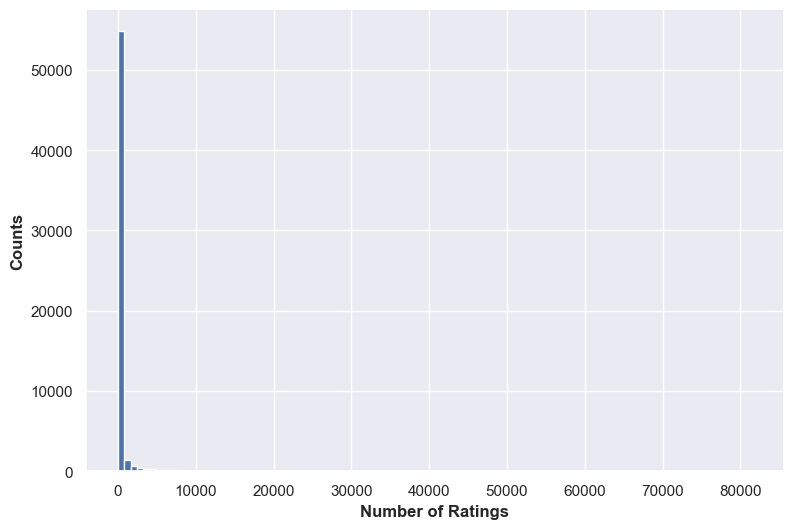

In [6]:
# Histogram of the number of reviews each movie has
plt.figure(figsize=(9, 6))
df_rating_count['count'].hist(bins=100)
plt.xlabel('Number of Ratings', fontweight='bold')
plt.ylabel('Counts', fontweight='bold')
plt.show();

Many movies have been rated very few times, these will include noise in the model so it will be better if they are removed.

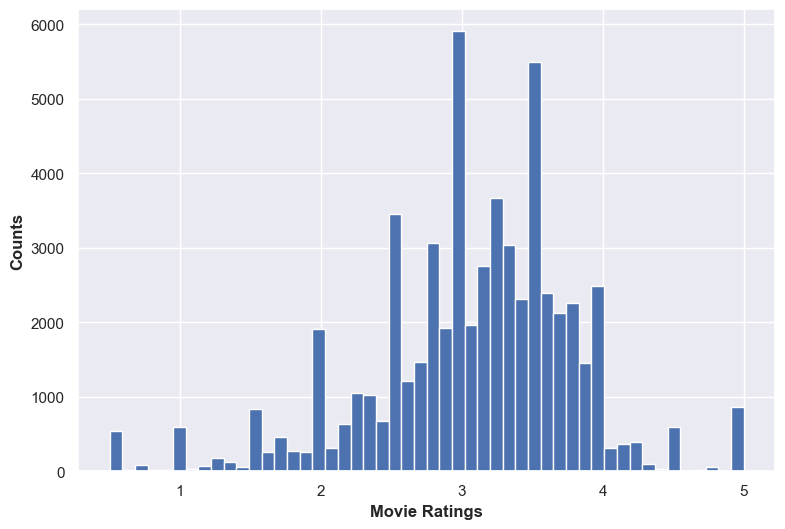

In [7]:
plt.figure(figsize=(9,6))
df_rating_count['rating'].hist(bins=50)
plt.xlabel('Movie Ratings', fontweight='bold')
plt.ylabel('Counts', fontweight='bold')
plt.show();

Here, we can see that majority of the movies are rated between 2.5 and 3.5, being 3 the most common rating. 

In [8]:
# Create a data frame with the number of ratings per user
user_df = pd.DataFrame(ratings_df.groupby('userId').size(), columns=['count'])
user_df.head()

,count
userId,
1,70
2,184
3,656
4,242
5,101


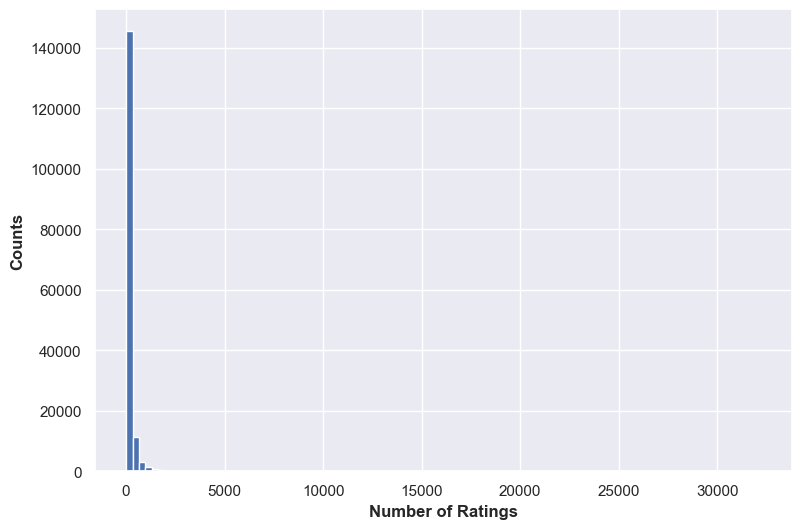

In [9]:
# Histogram of the number of reviews each movie has
plt.figure(figsize=(9, 6))
user_df['count'].hist(bins=100)
plt.xlabel('Number of Ratings', fontweight='bold')
plt.ylabel('Counts', fontweight='bold')
plt.show();

Again, we can see that many users have rated very little movies. We can remove those to get a better results. 

<Figure size 800x1000 with 0 Axes>

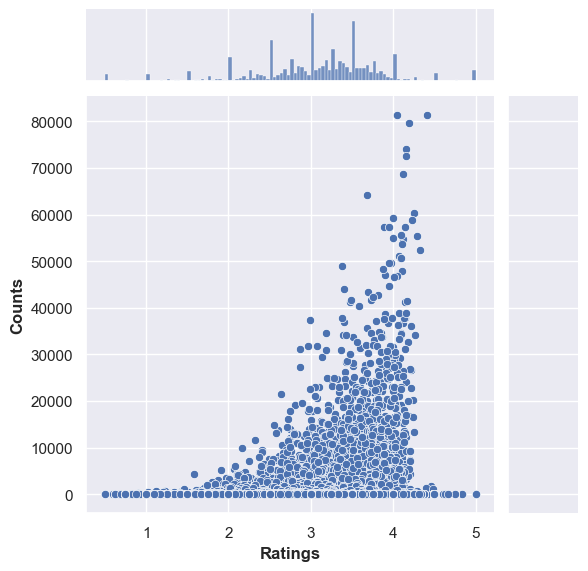

In [10]:
plt.figure(figsize=(8,10))
plt.rcParams['patch.force_edgecolor'] = True
figure = sns.jointplot(x='rating', y='count', data=df_rating_count, kind="scatter")
plt.subplots_adjust(bottom=0.15, top=0.99, left=0.15)
figure.set_axis_labels("Ratings", "Counts", fontweight='bold')

In [11]:
df_rating_count.head()

,rating,count
movieId,,
1,3.893708,57309
2,3.251527,24228
3,3.142028,11804
4,2.853547,2523
5,3.058434,11714


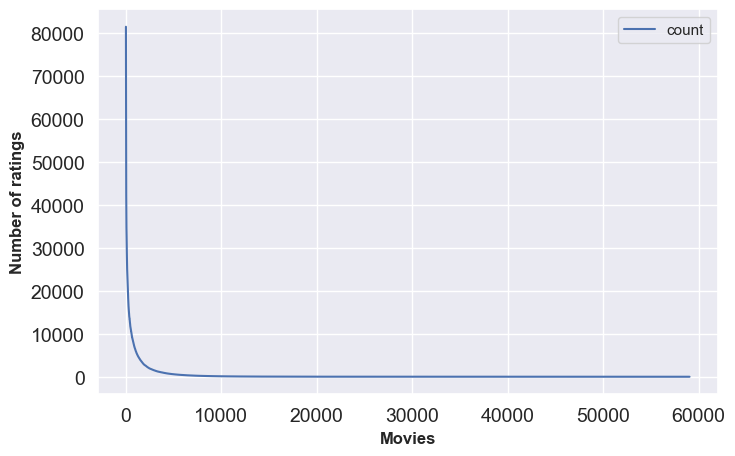

In [12]:
# rating frequency of all movies
ax = df_rating_count[['count']] \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(figsize=(8, 5), fontsize=14)
ax.set_xlabel("Movies", fontweight='bold')
ax.set_ylabel("Number of ratings", fontweight='bold')
plt.show();

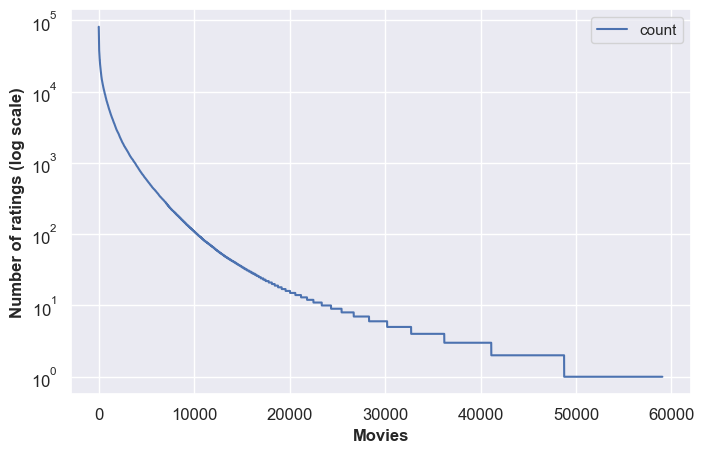

In [13]:
# plot rating frequency of all movies in log scale
ax = df_rating_count[['count']] \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(figsize=(8, 5), fontsize=12, logy=True)
ax.set_xlabel("Movies", fontweight='bold')
ax.set_ylabel("Number of ratings (log scale)", fontweight='bold')
plt.show();

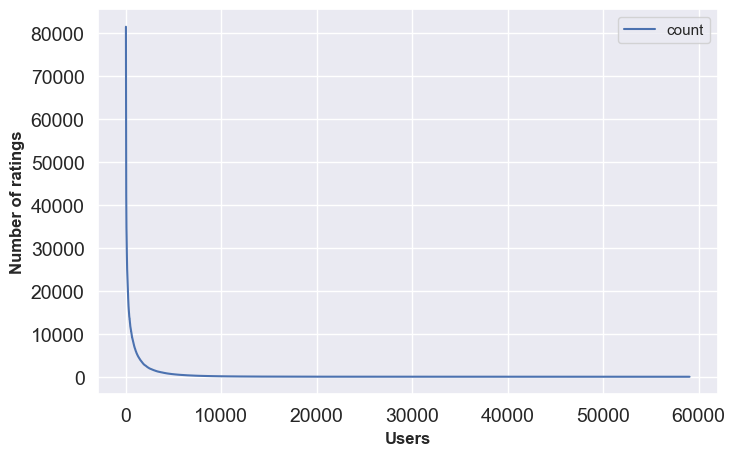

In [14]:
# plot rating frequency of all movies
ax = df_rating_count[['count']] \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(figsize=(8, 5), fontsize=14)
ax.set_xlabel("Users", fontweight='bold')
ax.set_ylabel("Number of ratings", fontweight='bold')
plt.show();

## Data preprocessing

Remove films that don't have at least 50 ratings:

In [15]:
# Select movies with at least 50 ratings
N = 50
popular_movies = list(df_rating_count.query('count >= @N').index)
ratings_df = ratings_df[ratings_df.movieId.isin(popular_movies)]

Same way, I'll be removing those users considered as inactive (or not very active), with less than 50 ratings.

In [16]:
active_users = list(user_df.query('count >= @N').index)
ratings_df = ratings_df[ratings_df.userId.isin(active_users)]

In [17]:
combined_data = pd.merge(ratings_df, movies_df, on='movieId')
combined_data = combined_data.drop(['genres'], axis=1)
combined_data.head()

,userId,movieId,rating,timestamp,title
0,1,296,5.0,1147880044,Pulp Fiction (1994)
1,1,306,3.5,1147868817,Three Colors: Red (Trois couleurs: Rouge) (1994)
2,1,307,5.0,1147868828,Three Colors: Blue (Trois couleurs: Bleu) (1993)
3,1,665,5.0,1147878820,Underground (1995)
4,1,899,3.5,1147868510,Singin' in the Rain (1952)


In [18]:
n_users = len(np.unique(combined_data['userId']))
n_items = len(np.unique(combined_data['movieId']))

print(f"Number of unique users: {n_users}")
print(f"Number of unique movies: {n_items}")

Number of unique users: 102492
Number of unique movies: 13176


## Split into train and test

In [19]:
# Extract unique user and movie IDs
user_ids = sorted(set(combined_data.iloc[:, 0]))
movie_ids = sorted(set(combined_data.iloc[:, 1]))

In [ ]:
test_size = 0.25
test = []

for user in user_ids:
    # get this user rating data
    user_rating = combined_data[combined_data['userId'] == user]
    # sort the user_rating data based on the timestamp
    user_rating = user_rating.sort_values(['timestamp'], ascending=True)
    # calculate the test size
    testing_samples = int(user_rating.shape[0] * test_size)
    # select the last records of this user as test samples
    indext = np.array(user_rating[-testing_samples:].index)
    test.extend(indext)

In [ ]:
test_df = combined_data[['userId', 'movieId', 'rating']].loc[test]
train_df = combined_data[['userId', 'movieId', 'rating']].drop(test)

In [ ]:
print(f"Original data shape: {combined_data.shape}")
print(f"test set shape: {test_df.shape}")
print(f"train set shape: {train_df.shape}")
print(test_df.shape[0] + train_df.shape[0])

In [22]:
print(f"Unique users in the test data set: {len(np.unique(test_df['userId']))}")
print(f"Unique movies in the test data set: {len(np.unique(test_df['movieId']))}")

print(f"Unique users in the train data set: {len(np.unique(train_df['userId']))}")
print(f"Unique movies in the train data set: {len(np.unique(train_df['movieId']))}")

Unique users in the test data set: 102492
Unique movies in the test data set: 13176
Unique users in the train data set: 102492
Unique movies in the train data set: 13175


The test data seems to have a movie that does not appear in the training data, since the ratings have been ordered by date, this would probably imply that the movie was released recently.

We have different options here:
* Drop the movie from the test set. If there are not many reviews and it doesn't mean losing too much information.
* Split the data following the same format (75% for training, 25% for testing). If we want to keep the movie, even though it may not add much because there are not a lot of rows.

In [24]:
movieIds_in_training = set(train_df['movieId'])
movie_ids = set(combined_data.iloc[:, 1])

print(f"Missing movieId: {movie_ids - movieIds_in_training}")

Missing movieId: {207830}


In [25]:
combined_data[combined_data['movieId'] == 207830].shape

(54, 5)

We only have 54 reviews for this movie. Even though it could be safe dropping it, I will opt for transfering 75% of those records to the train set.

In [26]:
movie = test_df[test_df['movieId'] == 207830]

In [27]:
movie.head()

,userId,movieId,rating
22723088,4515,207830,4.0
22723089,5264,207830,3.0
22723090,9852,207830,3.5
22723091,10919,207830,0.5
22723092,11539,207830,4.0


In [28]:
shuffled_movie = movie.sample(frac=1)
shuffled_movie.head()

,userId,movieId,rating
22723096,22349,207830,2.5
22723127,97074,207830,2.5
22723106,44621,207830,3.5
22723123,91400,207830,4.0
22723111,57775,207830,5.0


In [31]:
n_movies_for_training = int(shuffled_movie.shape[0] * 0.75)
movies_for_training = shuffled_movie[:n_movies_for_training]
remove_indexes = movies_for_training.index

In [33]:
print(f"Shape of the test df before dropping the rows: {test_df.shape}")
test_df = test_df.drop(remove_indexes)
print(f"Shape of the test df after dropping the rows: {test_df.shape}")

Shape of the test df before dropping the rows: (5651421, 3)
Shape of the test df after dropping the rows: (5651381, 3)


In [35]:
print(f"Shape of the train df before adding the rows: {train_df.shape}")
train_df = pd.concat([train_df, movies_for_training], ignore_index=True)
print(f"Shape of the train df after adding the rows: {train_df.shape}")

Shape of the train df before adding the rows: (17107802, 3)
Shape of the train df after adding the rows: (17107842, 3)


At this point we have the same number of items and users in both datasets

In [36]:
test_df.to_csv('./ml-25m/test_data.csv', index=False)
train_df.to_csv('./ml-25m/train_data.csv', index=False)

In [19]:
test_df = pd.read_csv('./ml-25m/test_data.csv')
train_df = pd.read_csv('./ml-25m/train_data.csv')

## Create the sparse matrix for training and testing

In [20]:
def create_sparse_matrix(data):
    # Extract unique user and movie IDs
    user_ids = sorted(set(data.iloc[:, 0]))
    movie_ids = sorted(set(data.iloc[:, 1]))
    
    # Create a dictionary to map user and movie IDs to their new indices
    # the key in those dictionaries is the original id of the user/movie while 
    # their value is the index that will be used to build the sparse matrix
    user_to_index = {user_id: i for i, user_id in enumerate(user_ids)}
    movie_to_index = {movie_id: i for i, movie_id in enumerate(movie_ids)}
    
    # To build the sparse matrix, each movie will be a row (m), whereas 
    # each user will represent a column (u), giving a matrix of shape m x u
    rows = [movie_to_index[m] for m in data['movieId'].values.tolist()]
    cols = [user_to_index[u] for u in data['userId'].values.tolist()]
    values = data['rating'].values.tolist()
        
    sparse_matrix = csr_matrix((values, (rows, cols)), shape=(n_items, n_users))

    return(sparse_matrix, movie_to_index)

In [21]:
sparse_train, movie_mapper_train = create_sparse_matrix(train_df)
sparse_test, movie_mapper_test = create_sparse_matrix(test_df)

## Creating the model to recommend movies

First, I'll create the model based on k-Nearest Neightbors algorithm

In [22]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5, n_jobs=1)
model_knn.fit(sparse_train)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=1)

I'm creating a dictionary to map the **original** movieId to the title of the movie.

In [23]:
movie_titles = dict(zip(movies_df['movieId'], movies_df['title']))

Now, another dictionary to map the index in the matrix to each of the movie titles:

In [24]:
new_index_title = {movie_mapper_train[k]: movie_titles[k] for k in movie_mapper_train}

Then, this function will give the top `N` recommendations:

In [25]:
def movie_recommender(movie_title, n_recommendations, sparse_matrix, movie_mapper):
    # Get the movieId in the movies_df data set
    movie_id = movies_df[movies_df['title'] == movie_title].movieId.iloc[0]

    # Convert that movieId to get its position in the sparse matrix
    matrix_index = movie_mapper[movie_id]

    for index in model_knn.kneighbors(sparse_matrix[matrix_index], n_recommendations+1)[1][0][1:]:
        print(new_index_title[index])        

In [26]:
movie_recommender('Star Wars: Episode IV - A New Hope (1977)', 10, sparse_train, movie_mapper_train)

Star Wars: Episode V - The Empire Strikes Back (1980)
Star Wars: Episode VI - Return of the Jedi (1983)
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
Matrix, The (1999)
Indiana Jones and the Last Crusade (1989)
Back to the Future (1985)
Terminator, The (1984)
Lord of the Rings: The Fellowship of the Ring, The (2001)
Alien (1979)
Terminator 2: Judgment Day (1991)


In [27]:
movie_recommender('Matrix, The (1999)', 10, sparse_train, movie_mapper_train)

Fight Club (1999)
Lord of the Rings: The Fellowship of the Ring, The (2001)
Star Wars: Episode V - The Empire Strikes Back (1980)
Lord of the Rings: The Two Towers, The (2002)
Lord of the Rings: The Return of the King, The (2003)
Star Wars: Episode IV - A New Hope (1977)
Gladiator (2000)
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
Sixth Sense, The (1999)
Saving Private Ryan (1998)


## Test the accuracy of the model

In [47]:
# Find top 20 similar movies for each user's highly rated movies
top_k = 20
threshold = 3.5

In [ ]:
# Create a mapping from movieId to matrix index
movie_index = {movie: index for index, movie in enumerate(train_ratings_matrix.index)}

In [ ]:
# Function to get top K similar movies
def get_top_k_similar(movie_id, k, similarity_matrix):
    movie_idx = new_index_title[movie_id]
    similarity_scores = list(enumerate(similarity_matrix[movie_idx]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    top_k_indices = [x[0] for x in similarity_scores[1:k+1]]
    top_k_movie_ids = [train_ratings_matrix.index[i] for i in top_k_indices]
    return top_k_movie_ids

In [222]:
# Get relevant data for a specific user (where the rating has been 4 or more)
user2_df = train_df[(train_df['userId'] == 92046) & (train_df['rating']>=4)][['movieId', 'rating']] #72315

In [223]:
# Convert the data into a dictionary where each movieId is the key and the rating is the value
movie_rating_dict = user2_df.set_index('movieId')['rating'].to_dict()

In [224]:
# Since the sparse matrix have a different index for each movie that the movieId, I need to create another dictionary
# to transform the previous one and map the information with those new indexes of the sparse matrix
index_rating_dict = {}

for k in movie_rating_dict:
    index_rating_dict[movie_mapper_train[k]] = movie_rating_dict[k]

In [225]:
# List to add the recommended indexes of the sparse matrix
top_recommended_indexes = []

# Dictionary to weight the distance of the movies
# I want to give more importance to the movies that 
# were rated with a 5 than the others
weights_dict = {5.0: 1.0, 
                4.5: 0.95,
                4.0: 0.9}

# Iterate through the dictionary to get the most similar movies
for i in index_rating_dict:
    distances, indexes = model_knn.kneighbors(sparse_train[i], 20+1)

    for (dist, ind) in zip(distances.squeeze()[1:], indexes.squeeze()[1:]):
        # I will append the movie if the user has not watched it already and the index hasn't been appended yet
        if ind not in index_rating_dict:
            w = weights_dict[index_rating_dict[i]] # calculate the weight 
            top_recommended_indexes.append((dist*w, ind)) 
            
top_recommended_indexes = sorted(top_recommended_movies, key=lambda x: x[0], reverse=True)    

In [226]:
len(top_recommended_indexes)

514

In [227]:
recommended_movies = set()

for _, i in top_recommended_indexes:
    if len(recommended_movies) < 1000:
        recommended_movies.add(index_to_movieId[i])
    else:
        break    

In [228]:
len(recommended_movies)

340

In [232]:
liked_test_movies = set(test_df[(test_df['userId'] == 92046) & (test_df['rating']>=3.5)].movieId)
disliked_test_movies = set(test_df[(test_df['userId'] == 92046) & (test_df['rating'] < 3.0)].movieId)

In [233]:
liked_difference = recommended_movies - liked_test_movies
print(len(liked_difference))

333


In [234]:
disliked_difference = recommended_movies - disliked_test_movies
print(len(disliked_difference))

333


In [188]:
index_to_movieId = {v: k for (k,v) in movie_mapper_train.items()}

In [189]:
movie_mapper_train[3495]

3073

In [190]:
index_to_movieId[3073]

3495

In [191]:
recommended_movieIds = []
for _, i in top_50_recommended:
    recommended_movieIds.append(index_to_movieId[i])

recommended_movies_set = set(recommended_movieIds)

In [192]:
liked_test_movies = set(test_df[(test_df['userId'] == 1) & (test_df['rating']>=3.5)].movieId)

In [193]:
disliked_test_movies = set(test_df[(test_df['userId'] == 1) & (test_df['rating'] < 3.5)].movieId)

In [194]:
difference = recommended_movies_set - liked_test_movies

In [195]:
len(difference)

168

In [196]:
len(recommended_movies_set)

170

In [197]:
disliked_difference = recommended_movies_set - disliked_test_movies
len(disliked_difference)

170

In [57]:
movies_df[movies_df['movieId'] == 1250]

,movieId,title,genres
1217,1250,"Bridge on the River Kwai, The (1957)",Adventure|Drama|War


In [55]:
movie_mapper_train[1250]

1106

In [56]:
sparse_train[1106].toarray()

array([[4., 0., 0., ..., 0., 0., 0.]])

In [65]:
distances, indexes = model_knn.kneighbors(sparse_train[1106], 5+1)

In [70]:
for (d, i) in zip(distances.squeeze()[1:], indexes.squeeze()[1:]):
    print(f"Distance: {d}, index: {i}")

Distance: 0.5262974518661587, index: 1063
Distance: 0.54578482763935, index: 1118
Distance: 0.5682831124920518, index: 1128
Distance: 0.573009006289209, index: 865
Distance: 0.5733032796265639, index: 808


In [125]:
test_df[['rating', 'userId']].groupby('userId').count().sort_values(by='rating', ascending=False)

,rating
userId,
72315,2642
80974,1726
20055,1706
33844,1560
92046,1463
...,...
59003,8
97364,7
97460,5


In [153]:
test_df[(test_df['userId'] == 72315) & (test_df['rating'] >= 3.5)]

,userId,movieId,rating
2514516,72315,2788,3.5
2514519,72315,6394,3.5
2514523,72315,45837,3.5
2514528,72315,26271,3.5
2514534,72315,5353,3.5
...,...,...,...
2517142,72315,193942,3.5
2517147,72315,201646,3.5
2517148,72315,722,4.5
2517149,72315,1872,3.5
